In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# import modules
from src.features import stat_tests as st
from src.features import calculate_chart_params as cp
from src.features import functions as fn
from src.features import plot_functions as pf

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

In [4]:
from sklearn.linear_model import LinearRegression

#### Simulate autocorrelated series

In [5]:
np.random.seed(12345)
arparams = np.array([.6])
maparams = np.array([0])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
y = arma_generate_sample(ar, ma, 100)

In [6]:
model = ARMA(y, (1, 0)).fit(trend='nc', disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                     ARMA(1, 0)   Log Likelihood                -144.398
Method:                       css-mle   S.D. of innovations              1.022
Date:                Sun, 08 Mar 2020   AIC                            292.796
Time:                        14:45:58   BIC                            298.006
Sample:                             0   HQIC                           294.904
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.7085      0.069     10.274      0.000       0.573       0.844
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4114           +0.0000j            1.4114            0.0000
-----------------------------------------------------------------------------
"""

In [7]:
model.params

array([0.70849537])

#### Analysis

In [8]:
y_series = pd.Series(y)

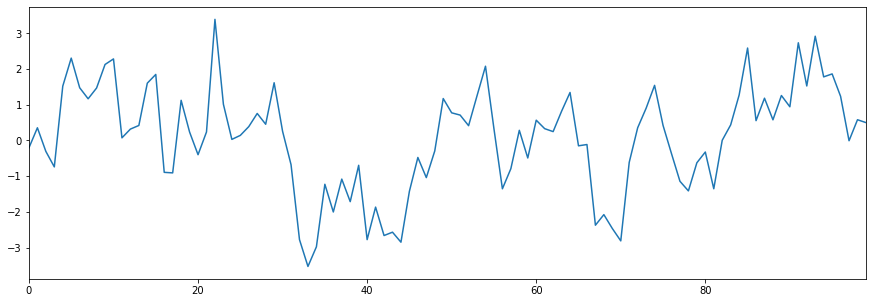

In [49]:
fig, ax = plt.subplots(figsize = (15,5))
y_series.plot.line()

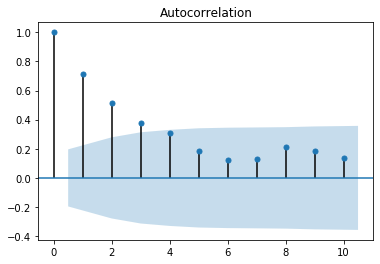

In [10]:
_ = plot_acf(y_series, lags=10)

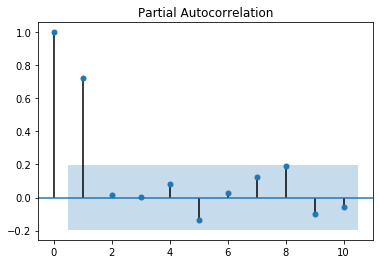

In [11]:
_ = plot_pacf(y_series, lags=10)

#### Analysis

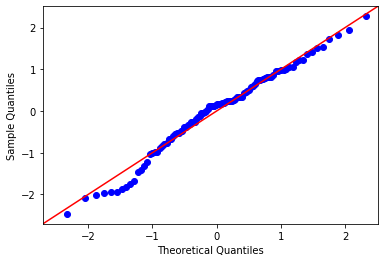

In [12]:
fig = qqplot(y_series, fit=True, line='45')
plt.show()

In [13]:
st.shapiro_wilks_(y_series)

Statistics=0.979, p=0.121
Sample looks Gaussian (fail to reject H0)


In [14]:
st.jarque_bera_(y_series)

Statistics=2.306, p=0.316, skew=-0.350, kurt=2.749
Sample looks Gaussian (fail to reject H0)


#### Individual control chart

In [15]:
in_control_mean = y_series.mean()

In [16]:
MR  = cp.calculate_MR(y_series)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [17]:
in_control_mean, in_control_sigma

(0.07651668611574132, 0.7883723913574395)

In [18]:
x_ind_params = cp.x_ind_params(x = y_series, sigma = in_control_sigma, center=0)

In [19]:
x_ind_params = x_ind_params.reset_index()

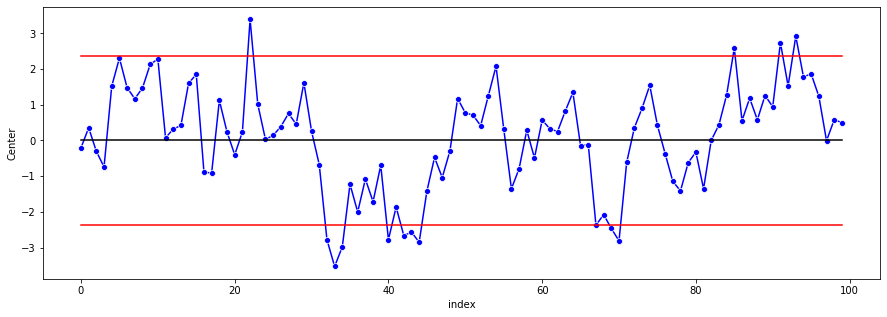

In [20]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title=None,
    ylab=None,
    xlab=None,
    all_dates=False,
    rot=0)

#### Model with AR(1)

In [21]:
data2 = x_ind_params.loc[:, ['index', 'obs']].copy()

In [22]:
data2['x1'] = data2['obs'].shift(periods = 1)
# data2['x2'] = data2['obs'].shift(periods = 2)

In [23]:
data2.dropna(inplace = True)

In [24]:
features= ['x1']

In [25]:
lm = LinearRegression(fit_intercept=True)
lm.fit(data2.loc[:, features].values, data2['obs'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
lm.intercept_, lm.coef_

(0.02775985172270625, array([0.71438844]))

In [27]:
# get residuals
residuals = pd.Series(data2['obs'].values - lm.predict(data2.loc[:, features].values))

#### Test residuals

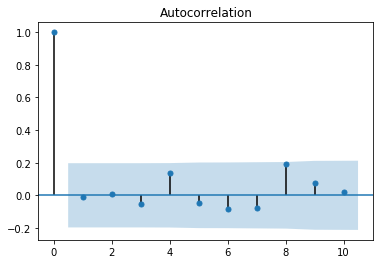

In [28]:
_ = plot_acf(residuals, lags=10)

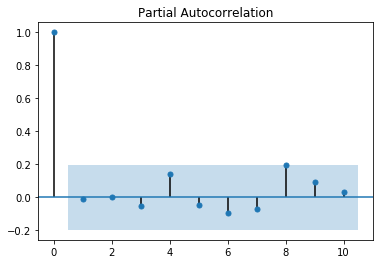

In [29]:
_ = plot_pacf(residuals, lags=10)

#### Analysis

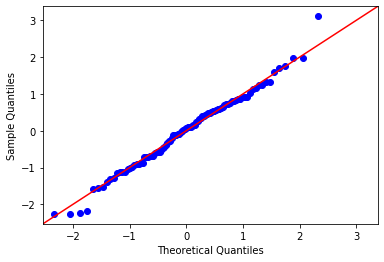

In [30]:
fig = qqplot(residuals, fit=True, line='45')
plt.show()

In [31]:
st.shapiro_wilks_(residuals)

Statistics=0.989, p=0.601
Sample looks Gaussian (fail to reject H0)


In [32]:
st.jarque_bera_(residuals)

Statistics=0.124, p=0.940, skew=0.025, kurt=3.166
Sample looks Gaussian (fail to reject H0)


#### Individual control chart for residuals

In [39]:
in_control_mean = residuals.mean()

In [40]:
MR  = cp.calculate_MR(residuals)
in_control_sigma = cp.estimate_sigma_from_MR(MR)

In [41]:
in_control_mean, in_control_sigma

(2.803593496528173e-17, 1.0408290302250849)

In [42]:
x_ind_params = cp.x_ind_params(x = residuals, sigma = in_control_sigma, center=0)

In [43]:
x_ind_params = x_ind_params.reset_index()

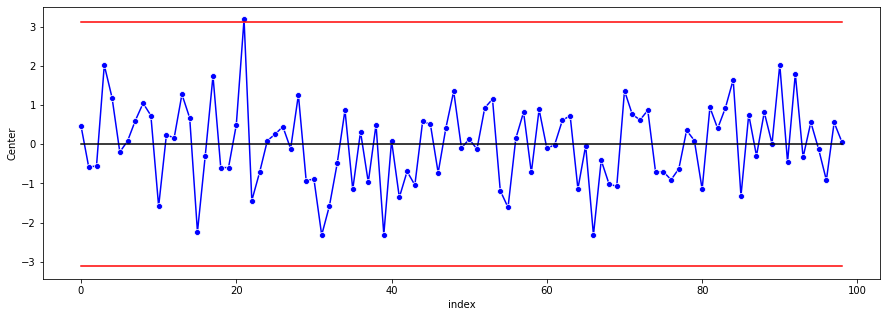

In [44]:
pf.plot_control_chart(
    data=x_ind_params,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='steps-mid',
    title=None,
    ylab=None,
    xlab=None,
    all_dates=False,
    rot=0)

#### Individual control chart for original x

In [45]:
x_ind_params_orig = fn.convert_residuals_to_original(x_ind_params, lm.predict(data2.loc[:, features].values))

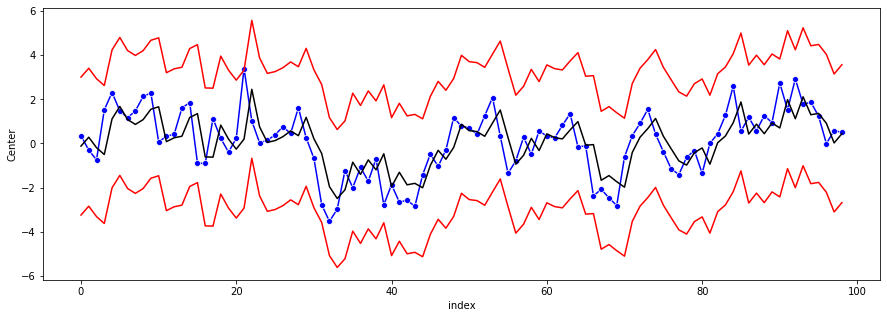

In [48]:
pf.plot_control_chart(
    data=x_ind_params_orig,
    index='index',
    obs='obs',
    UCL='UCL',
    center='Center',
    LCL='LCL',
    drawstyle='default',
    title=None,
    ylab=None,
    xlab=None,
    all_dates=False,
    rot=0)